In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import time
import matplotlib.pyplot as plt
import joblib
import os
import warnings


warnings.filterwarnings('ignore')

print("--- Step 1: Setting up Project Environment ---")


os.makedirs('loan-unlearning-project/data/raw', exist_ok=True)
os.makedirs('loan-unlearning-project/data/processed', exist_ok=True)
os.makedirs('loan-unlearning-project/models', exist_ok=True)
os.makedirs('loan-unlearning-project/results/graphs', exist_ok=True)


column_names = [
    'existing_checking_account', 'duration', 'credit_history', 'purpose',
    'credit_amount', 'savings_account_bonds', 'present_employment_since',
    'installment_rate_percentage', 'personal_status_sex', 'other_debtors_guarantors',
    'present_residence_since', 'property', 'age', 'other_installment_plans',
    'housing', 'number_of_existing_credits', 'job', 'number_of_people_liable',
    'telephone', 'foreign_worker', 'class'
]

print("Project directories and initial configuration are ready.\n")

--- Step 1: Setting up Project Environment ---
Project directories and initial configuration are ready.



In [3]:
print("--- Step 2: Loading and Preprocessing the Dataset ---")


!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data -O loan-unlearning-project/data/raw/german_credit.csv


df = pd.read_csv('loan-unlearning-project/data/raw/german_credit.csv',
                 delimiter=' ', header=None, names=column_names)


categorical_cols = df.select_dtypes(include=['object']).columns
encoders = {}
print("Encoding categorical features...")
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le


numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('class')

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
joblib.dump(scaler, 'loan-unlearning-project/models/scaler.pkl')


X = df.drop('class', axis=1)

y = df['class'].apply(lambda x: 1 if x == 1 else 0)


print("Applying PCA to reduce from 20 features to 10 components...")
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)
joblib.dump(pca, 'loan-unlearning-project/models/pca.pkl')


X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split complete: Training set shape is {X_train.shape}, Testing set shape is {X_test.shape}")
print("Data preprocessing finished.\n")

--- Step 2: Loading and Preprocessing the Dataset ---
Encoding categorical features...
Applying PCA to reduce from 20 features to 10 components...

Data split complete: Training set shape is (800, 10), Testing set shape is (200, 10)
Data preprocessing finished.



In [4]:
print("--- Step 3: Model Training (Before Unlearning) ---")


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()
rf_model.fit(X_train, y_train)
rf_training_time = time.time() - start_time
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
print(f"\nRandom Forest Training Time: {rf_training_time:.4f} seconds")
print(f"Random Forest Initial Accuracy: {rf_accuracy:.4f}")
joblib.dump(rf_model, 'loan-unlearning-project/models/random_forest.pkl')


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_training_time = time.time() - start_time
xgb_accuracy = accuracy_score(y_test, xgb_model.predict(X_test))
print(f"\nXGBoost Training Time: {xgb_training_time:.4f} seconds")
print(f"XGBoost Initial Accuracy: {xgb_accuracy:.4f}")
joblib.dump(xgb_model, 'loan-unlearning-project/models/xgboost_model.pkl')
print("\nInitial models trained and saved.\n")

--- Step 3: Model Training (Before Unlearning) ---

Random Forest Training Time: 0.6297 seconds
Random Forest Initial Accuracy: 0.7450

XGBoost Training Time: 0.9525 seconds
XGBoost Initial Accuracy: 0.6950

Initial models trained and saved.



In [5]:
print("--- Step 4: Machine Unlearning Simulation ---")


deletion_percentage = 0.40
num_to_delete = int(len(X_train) * deletion_percentage)
np.random.seed(42)
indices_to_delete = np.random.choice(X_train.shape[0], num_to_delete, replace=False)
X_train_remaining = np.delete(X_train, indices_to_delete, axis=0)
y_train_remaining = y_train.drop(y_train.index[indices_to_delete])
print(f"Simulating the deletion of {num_to_delete} ({deletion_percentage*100}%) data points.")


print("\nPerforming a full retrain on the remaining data...")
rf_retrain = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()
rf_retrain.fit(X_train_remaining, y_train_remaining)
full_retrain_time = time.time() - start_time
retrain_accuracy = accuracy_score(y_test, rf_retrain.predict(X_test))
print(f"Full Retraining Time: {full_retrain_time:.4f} seconds")
print(f"Accuracy after full retrain: {retrain_accuracy:.4f}")


print("\nPerforming unlearning with SISA...")
num_shards = 5
shard_size = int(np.ceil(len(X_train) / num_shards))
shards = [{'X': X_train[i*shard_size:min((i+1)*shard_size, len(X_train))],
           'y': y_train.iloc[i*shard_size:min((i+1)*shard_size, len(X_train))],
           'indices': list(range(i*shard_size, min((i+1)*shard_size, len(X_train))))}
          for i in range(num_shards)]
sisa_models = [RandomForestClassifier(n_estimators=20, random_state=42).fit(s['X'], s['y']) for s in shards]

start_time_sisa_unlearn = time.time()
affected_shards_indices = {i for del_idx in indices_to_delete for i, s in enumerate(shards) if del_idx in s['indices']}
for i in affected_shards_indices:
    remaining_mask = ~np.isin(shards[i]['indices'], indices_to_delete)
    sisa_models[i].fit(shards[i]['X'][remaining_mask], shards[i]['y'].iloc[remaining_mask])
sisa_unlearning_time = time.time() - start_time_sisa_unlearn
sisa_predictions = np.array([model.predict(X_test) for model in sisa_models])
y_pred_sisa = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=sisa_predictions)
sisa_accuracy = accuracy_score(y_test, y_pred_sisa)
print(f"SISA Unlearning Time: {sisa_unlearning_time:.4f} seconds")
print(f"SISA Accuracy after Unlearning: {sisa_accuracy:.4f}")


try:
    import dare
    print("\nPerforming unlearning with DaRE Forest...")
    dare_model = dare.Forest(n_estimators=100, random_state=42)
    dare_model.fit(X_train, y_train.to_numpy())
    start_time = time.time()
    for idx in sorted(indices_to_delete, reverse=True):
         dare_model.delete(idx)
    dare_unlearning_time = time.time() - start_time
    y_pred_dare = dare_model.predict(X_test)
    dare_accuracy = accuracy_score(y_test, y_pred_dare)
    print(f"DaRE Unlearning Time: {dare_unlearning_time:.4f} seconds")
    print(f"DaRE Accuracy after Unlearning: {dare_accuracy:.4f}")
    joblib.dump(dare_model, 'loan-unlearning-project/models/dare_forest.pkl')
    dare_available = True
except (ImportError, FileNotFoundError):
    print("\nDaRE Forest library not found. Using the fully retrained model as a substitute for comparison.")
    dare_model = rf_retrain
    dare_unlearning_time = full_retrain_time
    dare_accuracy = retrain_accuracy
    dare_available = False

print("\nUnlearning simulation complete.\n")

--- Step 4: Machine Unlearning Simulation ---
Simulating the deletion of 320 (40.0%) data points.

Performing a full retrain on the remaining data...
Full Retraining Time: 0.2958 seconds
Accuracy after full retrain: 0.7350

Performing unlearning with SISA...
SISA Unlearning Time: 0.1806 seconds
SISA Accuracy after Unlearning: 0.7400

DaRE Forest library not found. Using the fully retrained model as a substitute for comparison.

Unlearning simulation complete.




Retraining XGBoost on remaining data (post-deletion) for fair comparison...
XGBoost retrain time (after deletion): 0.1002 s
XGBoost accuracy after retrain: 0.7150

--- Performance Comparison Summary ---


,Method,Accuracy,Time (s)
0,Random Forest (Initial),0.745,0.629704
1,XGBoost (Initial),0.695,0.952519
2,Full Retrain (Naive) [RF],0.735,0.295815
3,XGBoost (After Deletion),0.715,0.100168
4,SISA (Unlearning),0.740,0.180583
5,DaRE (Unlearning),0.735,0.295815



Saved: loan-unlearning-project/results/accuracy_comparison.csv


--- Difference Table (Before vs After, and Delta) ---


,Method,Accuracy Before,Accuracy After,Accuracy Delta,Training Time (s),Unlearning Time (s)
0,Random Forest (Initial),0.7450,0.7350,-0.0100,0.6297,0.2958
1,XGBoost (Initial),0.6950,0.7150,0.0200,0.9525,0.1002
2,Full Retrain (Naive) [RF retrain],0.7450,0.7350,-0.0100,0.6297,0.2958
3,SISA (Unlearning),0.7450,0.7400,-0.0050,0.6297,0.1806
4,DaRE (Unlearning),0.7450,0.7350,-0.0100,0.6297,0.2958



Saved: loan-unlearning-project/results/difference_table.csv

--- Markdown Table ---
| Method | Accuracy Before | Accuracy After | Accuracy Delta | Training Time (s) | Unlearning Time (s) |
|---|---:|---:|---:|---:|---:|
| Random Forest (Initial) | 0.7450 | 0.7350 | -0.0100 | 0.6297 | 0.2958 |
| XGBoost (Initial) | 0.6950 | 0.7150 | 0.0200 | 0.9525 | 0.1002 |
| Full Retrain (Naive) [RF retrain] | 0.7450 | 0.7350 | -0.0100 | 0.6297 | 0.2958 |
| SISA (Unlearning) | 0.7450 | 0.7400 | -0.0050 | 0.6297 | 0.1806 |
| DaRE (Unlearning) | 0.7450 | 0.7350 | -0.0100 | 0.6297 | 0.2958 |


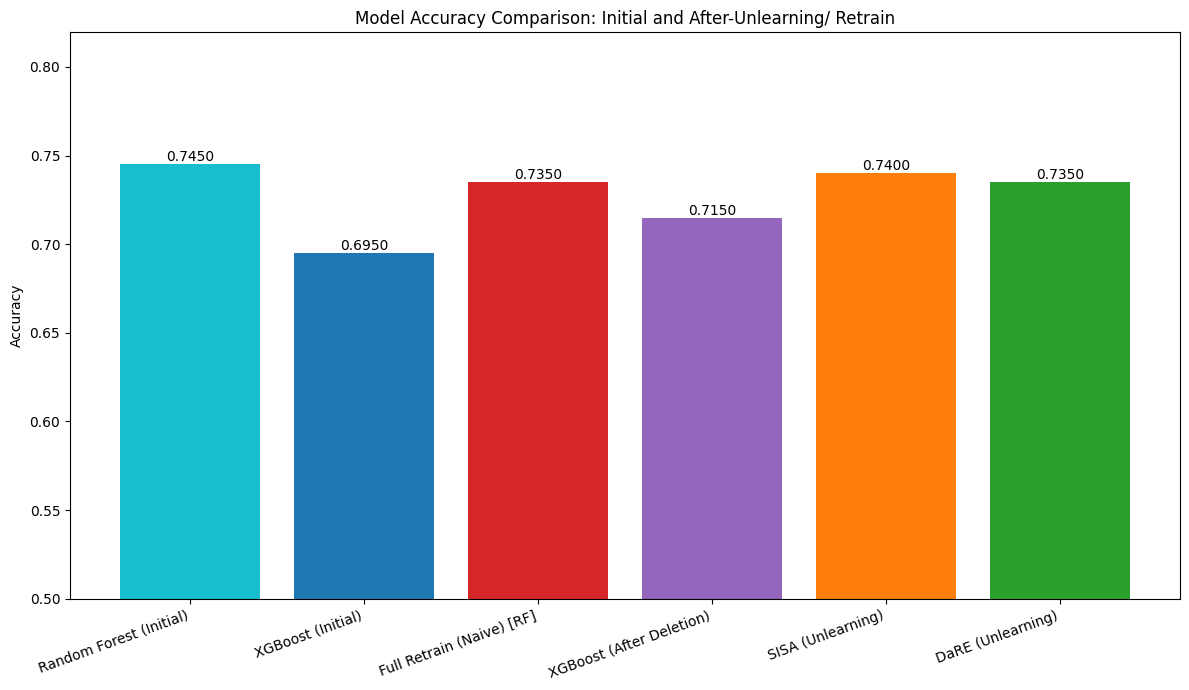

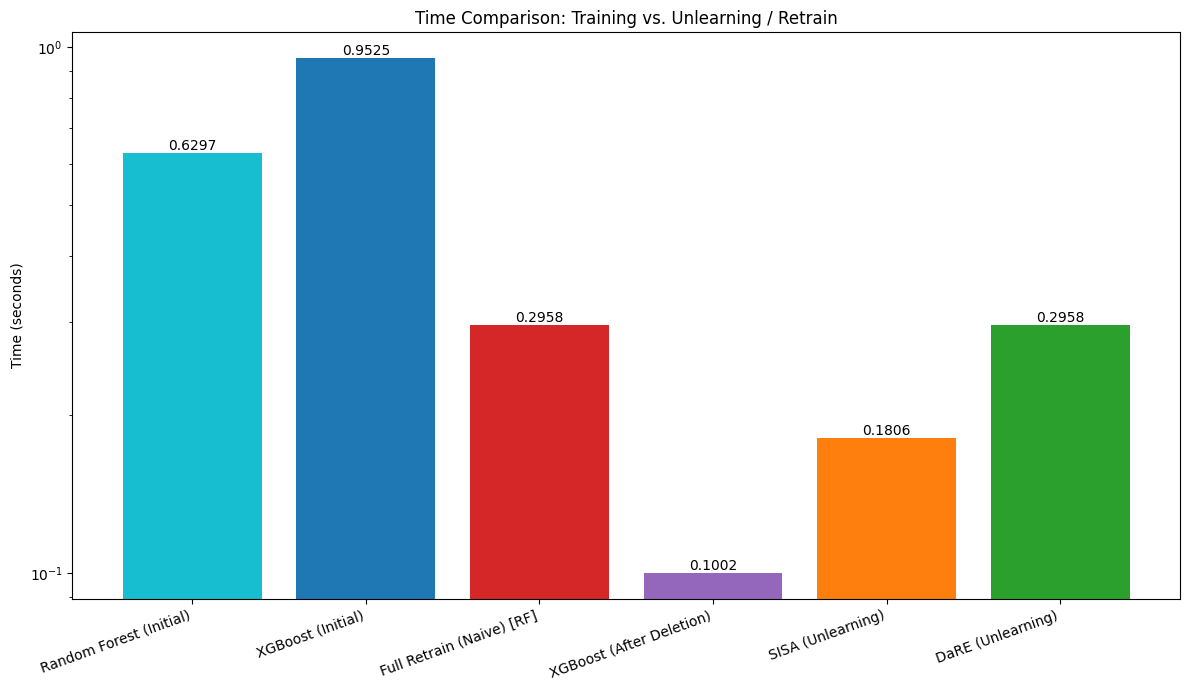


=== Updated performance and difference tables created and saved. ===


In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
import time

os.makedirs('loan-unlearning-project/results/graphs', exist_ok=True)


try:
    print("\nRetraining XGBoost on remaining data (post-deletion) for fair comparison...")
    xgb_retrain = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    start = time.time()
    xgb_retrain.fit(X_train_remaining, y_train_remaining)
    xgb_retrain_time = time.time() - start
    xgb_after = accuracy_score(y_test, xgb_retrain.predict(X_test))
    joblib.dump(xgb_retrain, 'loan-unlearning-project/models/xgb_retrained_after_deletion.pkl')
    print(f"XGBoost retrain time (after deletion): {xgb_retrain_time:.4f} s")
    print(f"XGBoost accuracy after retrain: {xgb_after:.4f}")
except Exception as e:
    print("Warning: XGBoost retrain failed or X_train_remaining not available. Setting XGBoost-after = NaN.")
    xgb_after = np.nan
    xgb_retrain_time = np.nan

performance_data = {
    'Method': ['Random Forest (Initial)', 'XGBoost (Initial)', 'Full Retrain (Naive) [RF]', 'XGBoost (After Deletion)', 'SISA (Unlearning)', 'DaRE (Unlearning)'],
    'Accuracy': [rf_accuracy, xgb_accuracy, retrain_accuracy, xgb_after, sisa_accuracy, dare_accuracy],
    'Time (s)': [rf_training_time, xgb_training_time, full_retrain_time, xgb_retrain_time, sisa_unlearning_time, dare_unlearning_time]
}
df_performance = pd.DataFrame(performance_data)
df_performance.to_csv('loan-unlearning-project/results/accuracy_comparison.csv', index=False)

print("\n--- Performance Comparison Summary ---")
display(df_performance)
print("\nSaved: loan-unlearning-project/results/accuracy_comparison.csv\n")

diff_rows = []

rf_after = retrain_accuracy
rf_delta = rf_after - rf_accuracy
diff_rows.append({
    'Method': 'Random Forest (Initial)',
    'Accuracy Before': rf_accuracy,
    'Accuracy After': rf_after,
    'Accuracy Delta': rf_delta,
    'Training Time (s)': rf_training_time,
    'Unlearning Time (s)': full_retrain_time
})

xgb_delta = xgb_after - xgb_accuracy if pd.notna(xgb_after) else np.nan
diff_rows.append({
    'Method': 'XGBoost (Initial)',
    'Accuracy Before': xgb_accuracy,
    'Accuracy After': xgb_after,
    'Accuracy Delta': xgb_delta,
    'Training Time (s)': xgb_training_time,
    'Unlearning Time (s)': xgb_retrain_time
})

diff_rows.append({
    'Method': 'Full Retrain (Naive) [RF retrain]',
    'Accuracy Before': rf_accuracy,
    'Accuracy After': retrain_accuracy,
    'Accuracy Delta': retrain_accuracy - rf_accuracy,
    'Training Time (s)': rf_training_time,
    'Unlearning Time (s)': full_retrain_time
})

diff_rows.append({
    'Method': 'SISA (Unlearning)',
    'Accuracy Before': rf_accuracy,
    'Accuracy After': sisa_accuracy,
    'Accuracy Delta': sisa_accuracy - rf_accuracy,
    'Training Time (s)': rf_training_time,
    'Unlearning Time (s)': sisa_unlearning_time
})

diff_rows.append({
    'Method': 'DaRE (Unlearning)',
    'Accuracy Before': rf_accuracy,
    'Accuracy After': dare_accuracy,
    'Accuracy Delta': dare_accuracy - rf_accuracy,
    'Training Time (s)': rf_training_time,
    'Unlearning Time (s)': dare_unlearning_time
})

df_difference = pd.DataFrame(diff_rows)
df_difference.to_csv('loan-unlearning-project/results/difference_table.csv', index=False)

df_display = df_difference.copy()
for col in ['Accuracy Before', 'Accuracy After', 'Accuracy Delta']:
    df_display[col] = df_display[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
for col in ['Training Time (s)', 'Unlearning Time (s)']:
    df_display[col] = df_display[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")

print("\n--- Difference Table (Before vs After, and Delta) ---")
display(df_display)
print("\nSaved: loan-unlearning-project/results/difference_table.csv\n")

print("--- Markdown Table ---")
print("| Method | Accuracy Before | Accuracy After | Accuracy Delta | Training Time (s) | Unlearning Time (s) |")
print("|---|---:|---:|---:|---:|---:|")
for _, row in df_difference.iterrows():
    ab = f"{row['Accuracy Before']:.4f}" if pd.notna(row['Accuracy Before']) else "N/A"
    aa = f"{row['Accuracy After']:.4f}" if pd.notna(row['Accuracy After']) else "N/A"
    ad = f"{row['Accuracy Delta']:.4f}" if pd.notna(row['Accuracy Delta']) else "N/A"
    tt = f"{row['Training Time (s)']:.4f}" if pd.notna(row['Training Time (s)']) else "N/A"
    ut = f"{row['Unlearning Time (s)']:.4f}" if pd.notna(row['Unlearning Time (s)']) else "N/A"
    print(f"| {row['Method']} | {ab} | {aa} | {ad} | {tt} | {ut} |")

plt.figure(figsize=(12, 7))
colors_acc = ['#17becf', '#1f77b4', '#d62728', '#9467bd', '#ff7f0e', '#2ca02c'][:len(df_performance)]
bars = plt.bar(df_performance['Method'], df_performance['Accuracy'], color=colors_acc)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison: Initial and After-Unlearning/ Retrain')
plt.ylim(0.5, max(df_performance['Accuracy'].dropna()) * 1.1)
plt.xticks(rotation=20, ha="right")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('loan-unlearning-project/results/graphs/accuracy_comparison_updated.png')
plt.show()

plt.figure(figsize=(12, 7))
bars = plt.bar(df_performance['Method'], df_performance['Time (s)'], color=colors_acc)
plt.ylabel('Time (seconds)')
plt.title('Time Comparison: Training vs. Unlearning / Retrain')
plt.yscale('log')
plt.xticks(rotation=20, ha="right")
for bar in bars:
    yval = bar.get_height()
    label = f'{yval:.4f}' if (pd.notna(yval) and yval>0) else "N/A"
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, label, va='bottom', ha='center', fontsize=10)
plt.tight_layout()
plt.savefig('loan-unlearning-project/results/graphs/time_comparison_updated.png')
plt.show()

print("\n=== Updated performance and difference tables created and saved. ===")


In [7]:
print("--- Step 6: Predictive Analysis with Descriptive User Input ---")


code_descriptions = {
    'existing_checking_account': {
        'A11': '< 0 DM',
        'A12': '0 <= ... < 200 DM',
        'A13': '>= 200 DM',
        'A14': 'no checking account'
    },
    'credit_history': {
        'A30': 'no credits taken/all credits paid back duly',
        'A31': 'all credits at this bank paid back duly',
        'A32': 'existing credits paid back duly till now',
        'A33': 'delay in paying off in the past',
        'A34': 'critical account/other credits existing (not at this bank)'
    },
    'purpose': {
        'A40': 'car (new)', 'A41': 'car (used)', 'A42': 'furniture/equipment',
        'A43': 'radio/television', 'A44': 'domestic appliances', 'A45': 'repairs',
        'A46': 'education', 'A48': 'retraining', 'A49': 'business', 'A410': 'others'
    },
    'savings_account_bonds': {
        'A61': '< 100 DM', 'A62': '100 <= ... < 500 DM', 'A63': '500 <= ... < 1000 DM',
        'A64': '>= 1000 DM', 'A65': 'unknown/no savings account'
    },
    'present_employment_since': {
        'A71': 'unemployed', 'A72': '< 1 year', 'A73': '1 <= ... < 4 years',
        'A74': '4 <= ... < 7 years', 'A75': '>= 7 years'
    },
    'personal_status_sex': {
        'A91': 'male: divorced/separated', 'A92': 'female: divorced/separated/married',
        'A93': 'male: single', 'A94': 'male: married/widowed', 'A95': 'female: single'
    },
    'other_debtors_guarantors': {'A101': 'none', 'A102': 'co-applicant', 'A103': 'guarantor'},
    'property': {
        'A121': 'real estate', 'A122': 'building society savings agreement/life insurance',
        'A123': 'car or other', 'A124': 'unknown/no property'
    },
    'other_installment_plans': {'A141': 'bank', 'A142': 'stores', 'A143': 'none'},
    'housing': {'A151': 'rent', 'A152': 'own', 'A153': 'for free'},
    'job': {
        'A171': 'unemployed/unskilled - non-resident', 'A172': 'unskilled - resident',
        'A173': 'skilled employee/official',
        'A174': 'management/self-employed/highly qualified employee/officer'
    },
    'telephone': {'A191': 'none', 'A192': 'yes, registered under the customers name'},
    'foreign_worker': {'A201': 'yes', 'A202': 'no'}
}


integer_cols = [
    'duration', 'installment_rate_percentage', 'present_residence_since',
    'age', 'number_of_existing_credits', 'number_of_people_liable'
]

def get_user_input_descriptive(columns, integer_cols):
    """
    Gets user input by showing descriptive text for categorical options.
    The user enters the corresponding code (e.g., 'A11').
    """
    print("\nPlease provide the following details for the loan applicant.")
    print("----------------------------------------------------------")
    user_data = {}

    for col in columns:
        if col in code_descriptions:

            print(f"\n--- Select an option for '{col}' ---")
            for code, description in code_descriptions[col].items():
                print(f"  {code}: {description}")

            valid_options = list(code_descriptions[col].keys())
            prompt = "Enter the code for your choice (e.g., A11): "
            while True:
                user_input = input(prompt)
                if user_input in valid_options:
                    user_data[col] = user_input
                    break
                else:
                    print(f"Invalid code. Please enter one of {valid_options}")

        elif col in integer_cols:

            prompt = f"\nEnter value for '{col}' (e.g., 24, 35): "
            while True:
                user_input = input(prompt)
                try:
                    user_data[col] = int(user_input)
                    break
                except ValueError:
                    print("Invalid input. Please enter a whole number (no decimals).")

        else:
            prompt = f"\nEnter value for '{col}' (e.g., 4870.0): "
            while True:
                user_input = input(prompt)
                try:
                    user_data[col] = float(user_input)
                    break
                except ValueError:
                    print("Invalid input. Please enter a number.")

    return pd.DataFrame([user_data])


new_applicant_df_raw = get_user_input_descriptive(column_names[:-1], integer_cols)


print("\nTransforming your input for the models (Encoding, Scaling, and PCA)...")
processed_df = new_applicant_df_raw.copy()


for col in categorical_cols:
    le = encoders[col]

    processed_df[col] = le.transform(processed_df[col])


processed_df[numerical_cols] = scaler.transform(processed_df[numerical_cols])


new_applicant_pca = pca.transform(processed_df)


pred_normal = xgb_model.predict(new_applicant_pca)[0]
status_normal = "Approved" if pred_normal == 1 else "Rejected"


pred_unlearn = dare_model.predict(new_applicant_pca)[0]
status_unlearn = "Approved" if pred_unlearn == 1 else "Rejected"
proba_unlearn = dare_model.predict_proba(new_applicant_pca)[0]
confidence_unlearn = proba_unlearn.max()


print("\n\n--- Loan Approval Prediction ---")
print("========================================")
print(f"For context, the original model (trained on all data) would have decided: '{status_normal}'")
print("----------------------------------------")
print("Final Verdict based on the UNLEARNED model (after forgetting 40% of data):")
print(f"-> Loan Status: {status_unlearn}")
print(f"-> Confidence: {confidence_unlearn:.2%}")
print("========================================")

print("\n--- Project execution complete. ---")

--- Step 6: Predictive Analysis with Descriptive User Input ---

Please provide the following details for the loan applicant.
----------------------------------------------------------

--- Select an option for 'existing_checking_account' ---
  A11: < 0 DM
  A12: 0 <= ... < 200 DM
  A13: >= 200 DM
  A14: no checking account


KeyboardInterrupt: Interrupted by user

In [8]:
RAW_CSV = os.path.join(BASE, "data", "raw", "german_credit.csv")

if not os.path.exists(PROCESSED_CSV):
    print(f"\n⚠️ Processed CSV not found at {PROCESSED_CSV}. Creating it from raw dataset...")
    if not os.path.exists(RAW_CSV):
        raise FileNotFoundError("Raw dataset missing. Please re-run Step 2 of your main project to download it.")

    df = pd.read_csv(RAW_CSV, delimiter=' ', header=None)
    df.insert(0, 'applicant_id', [f"APP{100000+i}" for i in range(len(df))])

    df.columns = [
        'applicant_id', 'existing_checking_account', 'duration', 'credit_history', 'purpose',
        'credit_amount', 'savings_account_bonds', 'present_employment_since',
        'installment_rate_percentage', 'personal_status_sex', 'other_debtors_guarantors',
        'present_residence_since', 'property', 'age', 'other_installment_plans',
        'housing', 'number_of_existing_credits', 'job', 'number_of_people_liable',
        'telephone', 'foreign_worker', 'class'
    ]

    os.makedirs(os.path.dirname(PROCESSED_CSV), exist_ok=True)
    df.to_csv(PROCESSED_CSV, index=False)
    print(f"✅ Created processed CSV at: {PROCESSED_CSV}")



⚠️ Processed CSV not found at loan-unlearning-project/data/processed/german_credit_clean.csv. Creating it from raw dataset...
✅ Created processed CSV at: loan-unlearning-project/data/processed/german_credit_clean.csv


In [9]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

os.makedirs('loan-unlearning-project/models', exist_ok=True)
os.makedirs('loan-unlearning-project/results', exist_ok=True)


column_names = [
    'existing_checking_account', 'duration', 'credit_history', 'purpose',
    'credit_amount', 'savings_account_bonds', 'present_employment_since',
    'installment_rate_percentage', 'personal_status_sex', 'other_debtors_guarantors',
    'present_residence_since', 'property', 'age', 'other_installment_plans',
    'housing', 'number_of_existing_credits', 'job', 'number_of_people_liable',
    'telephone', 'foreign_worker', 'class'
]

df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
    delimiter=' ', header=None, names=column_names
)

categorical_cols = df.select_dtypes(include=['object']).columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('class')

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
joblib.dump(scaler, 'loan-unlearning-project/models/scaler.pkl')

X = df.drop('class', axis=1)
y = df['class'] - 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training models WITHOUT PCA...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_acc_no_pca = accuracy_score(y_test, rf_model.predict(X_test))

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_acc_no_pca = accuracy_score(y_test, xgb_model.predict(X_test))

print("Training models WITH PCA...")
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
joblib.dump(pca, 'loan-unlearning-project/models/pca.pkl')

rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_pca.fit(X_train_pca, y_train)
rf_acc_pca = accuracy_score(y_test, rf_model_pca.predict(X_test_pca))

xgb_model_pca = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model_pca.fit(X_train_pca, y_train)
xgb_acc_pca = accuracy_score(y_test, xgb_model_pca.predict(X_test_pca))


results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Random Forest', 'XGBoost'],
    'PCA': ['No', 'No', 'Yes', 'Yes'],
    'Accuracy': [rf_acc_no_pca, xgb_acc_no_pca, rf_acc_pca, xgb_acc_pca]
})

print("\n--- Accuracy Comparison ---")
print(results)
results.to_csv('loan-unlearning-project/results/accuracy_comparison.csv', index=False)


Training models WITHOUT PCA...
Training models WITH PCA...

--- Accuracy Comparison ---
           Model  PCA  Accuracy
0  Random Forest   No     0.765
1        XGBoost   No     0.780
2  Random Forest  Yes     0.725
3        XGBoost  Yes     0.715


In [10]:

import os, shutil, json, joblib, csv
from datetime import datetime, timezone
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier

BASE = "loan-unlearning-project"
PROCESSED_CSV = os.path.join(BASE, "data", "processed", "german_credit_clean.csv")
BACKUP_DIR = os.path.join(BASE, "data", "backup")
SHARDS_DIR = os.path.join(BASE, "data", "shards")
MODELS_DIR = os.path.join(BASE, "models", "sisa")
RESULTS_DIR = os.path.join(BASE, "results")
DELETED_JSON = os.path.join(RESULTS_DIR, "deleted_ids.json")
DELETION_AUDIT = os.path.join(RESULTS_DIR, "deletion_audit.csv")

os.makedirs(BACKUP_DIR, exist_ok=True)
os.makedirs(SHARDS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)


def ensure_applicant_id(df_path=PROCESSED_CSV):
    if not os.path.exists(df_path):
        raise FileNotFoundError(f"Processed CSV not found at {df_path}. Run preprocessing first.")
    df = pd.read_csv(df_path)
    if 'applicant_id' not in df.columns:
        df.insert(0, 'applicant_id', [f"APP{100000+i}" for i in range(len(df))])
        shutil.copy2(df_path, os.path.join(BACKUP_DIR, f"proc_backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"))
        df.to_csv(df_path, index=False)
    return pd.read_csv(df_path)

def numericize_df(df, exclude_cols=('applicant_id','class')):
    df2 = df.copy()
    for col in df2.columns:
        if col in exclude_cols:
            continue
        if not np.issubdtype(df2[col].dtype, np.number):
            df2[col], _ = pd.factorize(df2[col], sort=True)
    return df2

def remap_target(df, target='class'):
    if target in df.columns:
        vals = set(df[target].unique())
        if vals == {1,2} or (1 in vals and 2 in vals):
            df[target] = df[target] - 1
    return df

def load_deleted_set():
    if os.path.exists(DELETED_JSON):
        with open(DELETED_JSON, 'r') as f:
            obj = json.load(f)
            return set(obj.get('deleted_ids', []))
    return set()

def persist_deleted_ids(new_ids, requester="interactive_user", reason="interactive deletion"):
    deleted = load_deleted_set()
    deleted.update(map(str, new_ids))
    with open(DELETED_JSON, 'w') as f:
        json.dump({'deleted_ids': sorted(list(deleted))}, f, indent=2)
    rec = {'timestamp_utc': datetime.now(timezone.utc).isoformat(),
           'requester': requester,
           'deleted_ids': ",".join(map(str, new_ids)),
           'reason': reason}
    write_header = not os.path.exists(DELETION_AUDIT)
    with open(DELETION_AUDIT, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=list(rec.keys()))
        if write_header:
            writer.writeheader()
        writer.writerow(rec)

def create_shards_and_train(df, n_shards=5, target='class'):
    df = remap_target(df, target)
    df = numericize_df(df)
    shard_size = int(np.ceil(len(df)/n_shards))
    for i in range(n_shards):
        shard_df = df.iloc[i*shard_size : min((i+1)*shard_size, len(df))].reset_index(drop=True)
        shard_path = os.path.join(SHARDS_DIR, f"shard_{i}.csv")
        shard_df.to_csv(shard_path, index=False)
        if shard_df.shape[0] == 0:
            joblib.dump(None, os.path.join(MODELS_DIR, f"shard_{i}_model.pkl"))
            continue
        X = shard_df.drop(columns=[target,'applicant_id'], errors='ignore')
        y = shard_df[target]
        model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X, y)
        joblib.dump(model, os.path.join(MODELS_DIR, f"shard_{i}_model.pkl"))
    print(f"Initialized {n_shards} shards and trained per-shard models.")

def load_shard_map(df, n_shards=5):
    shard_size = int(np.ceil(len(df)/n_shards))
    mapping = {}
    for idx, aid in enumerate(df['applicant_id'].astype(str).tolist()):
        mapping[str(aid)] = idx // shard_size
    return mapping

def retrain_shard(shard_idx, target='class'):
    shard_path = os.path.join(SHARDS_DIR, f"shard_{shard_idx}.csv")
    if not os.path.exists(shard_path):
        print(f"Shard {shard_idx} file missing; skipping retrain.")
        return
    s = pd.read_csv(shard_path)
    s = remap_target(s, target)
    s = numericize_df(s)
    if s.shape[0] == 0:
        joblib.dump(None, os.path.join(MODELS_DIR, f"shard_{shard_idx}_model.pkl"))
        print(f"Shard {shard_idx} empty -> saved None model.")
        return
    X = s.drop(columns=[target,'applicant_id'], errors='ignore')
    y = s[target]
    m = RandomForestClassifier(n_estimators=100, random_state=42).fit(X, y)
    joblib.dump(m, os.path.join(MODELS_DIR, f"shard_{shard_idx}_model.pkl"))
    print(f"Retrained model for shard {shard_idx}.")

def delete_from_shards_and_retrain(applicant_ids, requester="interactive_user", reason="sisa_deletion", n_shards=5, target='class'):
    ids = set(map(str, applicant_ids))
    df = ensure_applicant_id()
    mapping = load_shard_map(df, n_shards=n_shards)
    affected_shards = {mapping[i] for i in ids if i in mapping}
    if not affected_shards:
        print("No provided applicant_id found in processed CSV; nothing to delete.")
        return

    shutil.copy2(PROCESSED_CSV, os.path.join(BACKUP_DIR, f"processed_before_sisa_del_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"))
    shutil.copytree(SHARDS_DIR, os.path.join(BACKUP_DIR, f"shards_backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}"), dirs_exist_ok=True)

    for shard_idx in affected_shards:
        shard_path = os.path.join(SHARDS_DIR, f"shard_{shard_idx}.csv")
        if not os.path.exists(shard_path):
            continue
        shard_df = pd.read_csv(shard_path)
        before = len(shard_df)
        shard_df = shard_df[~shard_df['applicant_id'].astype(str).isin(ids)].reset_index(drop=True)
        shard_df.to_csv(shard_path, index=False)
        print(f"Shard {shard_idx}: removed {before - len(shard_df)} row(s).")
        retrain_shard(shard_idx, target)

    processed_df = pd.read_csv(PROCESSED_CSV)
    before_all = len(processed_df)
    processed_df = processed_df[~processed_df['applicant_id'].astype(str).isin(ids)].reset_index(drop=True)
    processed_df.to_csv(PROCESSED_CSV, index=False)
    print(f"Processed CSV: removed {before_all - len(processed_df)} row(s). Saved updated processed file.")
    persist_deleted_ids(ids, requester=requester, reason=reason)
    print(f"Persisted deletion record for applicant_id(s): {sorted(list(ids))}.")


def handle_data_request_interactive(applicant_ids):
    ids = list(map(str, applicant_ids))
    deleted = load_deleted_set()
    deleted_match = [i for i in ids if i in deleted]
    if deleted_match:
        print(f"\nResponse: DENIED — The following applicant_id(s) were previously deleted and are not available: {deleted_match}")
        if os.path.exists(DELETION_AUDIT):
            audits = pd.read_csv(DELETION_AUDIT)
            related = audits[audits['deleted_ids'].str.contains("|".join(deleted_match))]
            if not related.empty:
                print("\nDeletion audit entries (recent):")
                print(related.tail(5))
        return {'status': 'denied', 'deleted': deleted_match}
    else:
        df = ensure_applicant_id()
        found = df[df['applicant_id'].isin(ids)]
        if found.empty:
            print("\nResponse: NOT FOUND — No records matched the provided applicant_id(s).")
            return {'status': 'not_found'}
        else:
            print(f"\nResponse: OK — Data available for applicant_id(s): {list(found['applicant_id'])}")
            print(found.head(len(found)))
            return {'status': 'ok', 'data': found}


if __name__ == "__main__":
    print("\n==== Applicant ID Viewer & SISA Deletion Utility ====\n")
    df_proc = ensure_applicant_id()
    n_shards_default = 5

    shards_exist = any(f.startswith('shard_') for f in os.listdir(SHARDS_DIR)) and any(f.endswith('_model.pkl') for f in os.listdir(MODELS_DIR))
    if not shards_exist:
        print("Initializing shards & per-shard models (SISA setup)...")
        create_shards_and_train(df_proc, n_shards=n_shards_default)
    else:
        print("SISA shards and models already present. Skipping initialization.")


    print("\nShowing sample applicant IDs (first 15):")
    print(df_proc['applicant_id'].astype(str).head(15).tolist())

    user_input = input("\nEnter applicant_id(s) to DELETE (comma-separated), or press Enter to skip deletion: ").strip()
    if user_input:
        ids_to_delete = [s.strip() for s in user_input.split(",") if s.strip()]
        print(f"\nWill delete: {ids_to_delete}")
        confirm = input("Type 'YES' to confirm deletion, anything else to cancel: ").strip()
        if confirm == 'YES':
            delete_from_shards_and_retrain(ids_to_delete, requester="interactive_demo", reason="interactive SISA deletion", n_shards=n_shards_default)
        else:
            print("Deletion cancelled by user.")
    else:
        print("No deletion requested. Skipping deletion step.")

    query_input = input("\nEnter applicant_id(s) to QUERY (comma-separated), or press Enter to finish: ").strip()
    if query_input:
        ids_to_query = [s.strip() for s in query_input.split(",") if s.strip()]
        handle_data_request_interactive(ids_to_query)
    else:
        print("No query requested. End of interactive session.")

    print("\n==== Done ====\n")



==== Applicant ID Viewer & SISA Deletion Utility ====

Initializing shards & per-shard models (SISA setup)...
Initialized 5 shards and trained per-shard models.

Showing sample applicant IDs (first 15):
['APP100000', 'APP100001', 'APP100002', 'APP100003', 'APP100004', 'APP100005', 'APP100006', 'APP100007', 'APP100008', 'APP100009', 'APP100010', 'APP100011', 'APP100012', 'APP100013', 'APP100014']


KeyboardInterrupt: Interrupted by user

In [11]:
import os

os.makedirs("my_project", exist_ok=True)


In [15]:
!mv *mini project.ipynb my_project/



mv: cannot stat '*mini': No such file or directory
mv: cannot stat 'project.ipynb': No such file or directory
